# Solving differential equations system 

To solve differential equation system it is again nessecary to perform the following workflow:

1. Define Models
2. Create residual function
3. Find the optimal constants using lmfit


## Step 1 defining the models

The basic procedure is the same, but there are differences:

- The initial conditions (**y0_array**) are defined as array and NOT as scalar
- There are two differential equations defined and **returned** as array

```
y0_array = [100,0]

def dglsys(init_cond_array, t,A0, kA, kB):
    A = init_cond_array[0]
    P = init_cond_array[1]
    dAdt = -kA*A
    dPdt = kB*(A0-(A0-A))
    dzdt = [dAdt, dPdt]
    return dzdt

```

## Step 2 defining the residual function

The residual function calculates the difference between the measured and the modelled values. Of course we need to create the `lmfit.Parameters()` object with the to be determined constants In the case of a **dgl-system** we will receive an array of integrated values and therefore need to also compare arrays with one another:

```
params = lmfit.Parameters()
params.add('kA', 2, min=0.00000001, max=3)
params.add('kP', 2, min=0.0000000001, max=3)

def residual(params, time, data_sets):
    kA = params['kA'].value
    kP = params['kP'].value
    ymodel=odeint(dglsys, y0_array, time, args=(100, kA, kP))
    substr = data_sets[0]-ymodel[:,0] # array 1
    product = data_sets[1]-ymodel[:,1] # array 2
    result = [substr, product] # result is returned as array
    return np.array(result)

```

3. Find the optimal constants using lmfit-minimize

And finally we can fit the constants by the minimize function of lmfit:

- In this case the data array will consist of two columns since we have to fit two different parameters

`solution = lmfit.minimize(residual, params, args=(np.array(time), data))`





   T [min]     Butanal   butyroin  4,5-octanediol
0        0  235.403070   0.000000             0.0
1       15  136.667003  35.135764             0.0
2       30   78.775571  59.773672             0.0
3       60   39.501736  80.610846             0.0
4      140   15.373700  85.416647             0.0


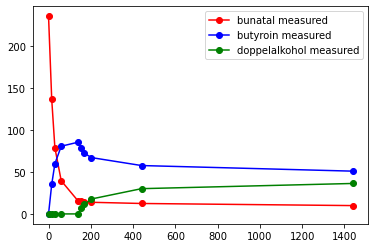

In [73]:
from scipy.integrate import odeint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import lmfit

df = pd.read_excel(r"4,5-ODO Upscaling.xlsx")

print(df.head())


time = df["T [min]"]
substrate = df["Butanal"]
product = df["butyroin"]
product2 = df["4,5-octanediol"]


fix, ax = plt.subplots()

ax.plot(time, substrate, label="bunatal measured", color="red", linestyle="-", marker="o")
ax.plot(time, product, label="butyroin measured", color="blue", linestyle="-", marker="o")
ax.plot(time, product2, label="doppelalkohol measured", color="green", linestyle="-", marker="o")
ax.legend()

#plt.show()

In [80]:
# Definition of DGL system
# A = Initial conditions
# t = time or x-values
# kA = Constant A
# kB = Constant B
y0 = 100



data_list = [substrate, product]

data = np.array(data_list)

print(data)


y0_array = [240, 0, 0]
print(y0_array)

def dglsys(init_cond_array, t, kA, kB, kC):
    A = init_cond_array[0]
    P = init_cond_array[1]
    C = init_cond_array[2]
    dAdt = -kA*A**2 + kB*P
    dBdt = (kA*A**2)*0.5 - kB*P + kC*C
    dCdt = kB*P - kC*C
    dZdt = np.array([dAdt, dBdt, dCdt])
    return dZdt

sol = odeint(dglsys, y0_array, time, args=(0.00027, 0.002, 0.000003))



params = lmfit.Parameters()
params.add('kA', 2, min=0.00000001, max=3)
params.add('kP', 2, min=0.0000000001, max=3)
params.add('kC', 2, min=0.0000000001, max=3)

def residual(params, time, data_sets):
    kA = params['kA'].value
    kP = params['kP'].value
    kC = params['kC'].value
    ymodel=odeint(dglsys, y0_array, time, args=(kA, kP, kC))
    substr = data_sets[0]-ymodel[:,0] # array 1
    product = data_sets[1]-ymodel[:,1] # array 2
    product2 = data_sets[2]-ymodel[:,2]
    result = [substr, product, product2] # result is returned as array
    return np.array(result)

solution = lmfit.minimize(residual, params, args=(np.array(time), data))
print(lmfit.report_fit(solution))


fig, ax = plt.subplots()
ax.plot(time, substrate, label="Substrate concentration", color="red", linestyle="", marker="o")
ax.plot(time, product, label="Substrate concentration", color="blue", linestyle="", marker="o")
ax.plot(time, sol[:,2], label="modelled product concentration2", linestyle="--")
ax.plot(time, sol[:,0], label="modelled substrate substrate", color="red", linestyle="--")
ax.plot(time, sol[:,1], label="modelled product substrate", color="red", linestyle="--")


ax.legend()
plt.savefig("testfig.svg", format="svg")
plt.show()


[[235.40306997 136.66700304  78.77557135  39.50173584  15.37370005
   15.13829237  14.49406891  13.84240584  12.42792802   9.91667821]
 [  0.          35.13576358  59.77367168  80.61084579  85.41664722
   78.41427103  72.13699274  67.0658672   57.60108041  50.92454335]]
[240, 0, 0]


C:\Users\SMalz\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


IndexError: index 2 is out of bounds for axis 0 with size 2

[[235.40306997 136.66700304  78.77557135  39.50173584  15.37370005
   15.13829237  14.49406891  13.84240584  12.42792802   9.91667821]
 [  0.          35.13576358  59.77367168  80.61084579  85.41664722
   78.41427103  72.13699274  67.0658672   57.60108041  50.92454335]
 [  0.           0.           0.           0.           0.
    6.78494113  11.32583558  17.78875041  30.07338747  36.26918197]]
[240, 0, 0]
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 92
    # data points      = 30
    # variables        = 4
    chi-square         = 3738.57415
    reduced chi-square = 143.791314
    Akaike info crit   = 152.757866
    Bayesian info crit = 158.362655
[[Variables]]
    kA:  2.6891e-04 +/- 3.2023e-05 (11.91%) (init = 2)
    kP:  0.00110048 +/- 3.4559e-04 (31.40%) (init = 2)
    kC:  0.68114324 +/- 1.41665484 (207.98%) (init = 2)
    kD:  2.98389980 +/- 6.17264135 (206.86%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(kC, kD) = 0.99

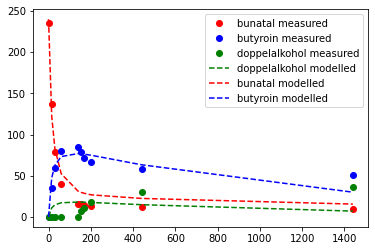

In [81]:
# Definition of DGL system
# A = Initial conditions
# t = time or x-values
# kA = Constant A
# kB = Constant B
y0 = 100



data_list = [substrate, product, product2]

data = np.array(data_list)

print(data)


y0_array = [240, 0, 0]
print(y0_array)

def dglsys(init_cond_array, t, kA, kB, kC, kD):
    A = init_cond_array[0]
    P = init_cond_array[1]
    C = init_cond_array[2]
    dAdt = -kA*A**2 + kB*P
    dBdt = (kA*A**2)*0.5 - kB*P - kC*P + kD*C
    dCdt = kC*P - kD*C
    dZdt = np.array([dAdt, dBdt, dCdt])
    return dZdt

sol = odeint(dglsys, y0_array, time, args=(0.00027, 0.002, 0.68, 2.9))



params = lmfit.Parameters()
params.add('kA', 2, min=0.00000001, max=3)
params.add('kP', 2, min=0.0000000001, max=3)
params.add('kC', 2, min=0.0000000001, max=3)
params.add('kD', 2, min=0.0000000001, max=3)

def residual(params, time, data_sets):
    kA = params['kA'].value
    kP = params['kP'].value
    kC = params['kC'].value
    kD = params['kD'].value
    
    ymodel=odeint(dglsys, y0_array, time, args=(kA, kP, kC, kD))
    substr = data_sets[0]-ymodel[:,0] # array 1
    product = data_sets[1]-ymodel[:,1] # array 2
    product2 = data_sets[2]-ymodel[:,2]
    result = [substr, product, product2] # result is returned as array
    return np.array(result)

solution = lmfit.minimize(residual, params, args=(np.array(time), data))
print(lmfit.report_fit(solution))


fig, ax = plt.subplots()
ax.plot(time, substrate, label="bunatal measured", color="red", linestyle="", marker="o")
ax.plot(time, product, label="butyroin measured", color="blue", linestyle="", marker="o")
ax.plot(time, product2, label="doppelalkohol measured", color="green", linestyle="", marker="o")

ax.plot(time, sol[:,2], label="doppelalkohol modelled", linestyle="--", color="green")
ax.plot(time, sol[:,0], label="bunatal modelled", linestyle="--", color="red")
ax.plot(time, sol[:,1], label="butyroin modelled", linestyle="--", color = "blue")


ax.legend()
plt.savefig("testfig.svg", format="svg")
plt.show()

[[235.40306997 136.66700304  78.77557135  39.50173584  15.37370005
   15.13829237  14.49406891  13.84240584  12.42792802   9.91667821]
 [  0.          35.13576358  59.77367168  80.61084579  85.41664722
   78.41427103  72.13699274  67.0658672   57.60108041  50.92454335]
 [  0.           0.           0.           0.           0.
    6.78494113  11.32583558  17.78875041  30.07338747  36.26918197]]
[240, 0, 0]
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 96
    # data points      = 30
    # variables        = 5
    chi-square         = 3730.83814
    reduced chi-square = 149.233525
    Akaike info crit   = 154.695724
    Bayesian info crit = 161.701711
[[Variables]]
    kA:   2.6850e-04 +/- 3.1903e-05 (11.88%) (init = 2)
    kP:   0.00109254 +/- 3.8332e-04 (35.09%) (init = 2)
    kC:   1.71596831 +/- 3.88285002 (226.28%) (init = 2)
    kD:   0.51954958 +/- 0.72761890 (140.05%) (init = 2)
    lag:  0.06955476 +/- 0.08004113 (115.08%) (init = 2)
[[Correlations

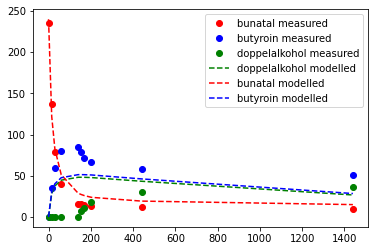

In [70]:
# Definition of DGL system
# A = Initial conditions
# t = time or x-values
# kA = Constant A
# kB = Constant B
y0 = 100



data_list = [substrate, product, product2]

data = np.array(data_list)

print(data)


y0_array = [240, 0, 0]
print(y0_array)

def dglsys(init_cond_array, t, kA, kB, kC, kD, lag):
    A = init_cond_array[0]
    P = init_cond_array[1]
    C = init_cond_array[2]
    dAdt = -kA*A**2 + kB*P
    dBdt = (kA*A**2)*0.5 - kB*P - lag*kC*P + kD*C
    dCdt = lag*kC*P - kD*C
    dZdt = np.array([dAdt, dBdt, dCdt])
    return dZdt

sol = odeint(dglsys, y0_array, time, args=(0.00027, 0.002, 0.68, 2.9, 4))



params = lmfit.Parameters()
params.add('kA', 2, min=0.00000001, max=3)
params.add('kP', 2, min=0.0000000001, max=3)
params.add('kC', 2, min=0.0000000001, max=3)
params.add('kD', 2, min=0.0000000001, max=3)
params.add('lag', 2, min=0.0001, max=10)

def residual(params, time, data_sets):
    kA = params['kA'].value
    kP = params['kP'].value
    kC = params['kC'].value
    kD = params['kD'].value
    lag = params['lag'].value
    
    ymodel=odeint(dglsys, y0_array, time, args=(kA, kP, kC, kD, lag))
    substr = data_sets[0]-ymodel[:,0] # array 1
    product = data_sets[1]-ymodel[:,1] # array 2
    product2 = data_sets[2]-ymodel[:,2]
    result = [substr, product, product2] # result is returned as array
    return np.array(result)

solution = lmfit.minimize(residual, params, args=(np.array(time), data))
print(lmfit.report_fit(solution))


fig, ax = plt.subplots()
ax.plot(time, substrate, label="bunatal measured", color="red", linestyle="", marker="o")
ax.plot(time, product, label="butyroin measured", color="blue", linestyle="", marker="o")
ax.plot(time, product2, label="doppelalkohol measured", color="green", linestyle="", marker="o")

ax.plot(time, sol[:,2], label="doppelalkohol modelled", linestyle="--", color="green")
ax.plot(time, sol[:,0], label="bunatal modelled", linestyle="--", color="red")
ax.plot(time, sol[:,1], label="butyroin modelled", linestyle="--", color = "blue")


ax.legend()
plt.savefig("testfig.svg", format="svg")